In [328]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [329]:
# read csv
power_actual = pd.read_csv('../data/power_actual.csv', parse_dates=['datetime'], infer_datetime_format=True)
weather_actuals = pd.read_csv('../data/weather_actuals.csv', parse_dates=['datetime_local'], infer_datetime_format=True)
weather_forecast = pd.read_csv('../data/weather_forecast.csv', parse_dates=['datetime_local'], infer_datetime_format=True)

In [330]:
# shape
print("Power Actual", power_actual.shape)
print("Weather Actual", weather_actuals.shape)
print("Weather Forecast", weather_forecast.shape)

Power Actual (70080, 5)
Weather Actual (13619, 31)
Weather Forecast (648, 31)


In [331]:
print("Power Actual Columns", power_actual.columns)
print("Weather Actual Columns", weather_actuals.columns)
print("Weather Forecast Columns", weather_forecast.columns)

Power Actual Columns Index(['Unnamed: 0', 'datetime', 'ghi', 'gti', 'power'], dtype='object')
Weather Actual Columns Index(['Unnamed: 0', 'plant_id', 'datetime_utc', 'datetime_local',
       'cloud_cover', 'apparent_temperature', 'temperature', 'humidity',
       'dew_point', 'wind_bearing', 'wind_speed', 'wind_chill', 'wind_gust',
       'heat_index', 'pressure', 'qpf', 'uv_index', 'snow', 'pop', 'fctcode',
       'ozone', 'precip_accumulation', 'precip_intensity',
       'precip_probability', 'precip_type', 'visibility', 'sunrise', 'sunset',
       'icon', 'summary', 'updated_at'],
      dtype='object')
Weather Forecast Columns Index(['Unnamed: 0', 'plant_id', 'datetime_utc', 'datetime_local',
       'cloud_cover', 'apparent_temperature', 'temperature', 'humidity',
       'dew_point', 'wind_bearing', 'wind_speed', 'wind_chill', 'wind_gust',
       'heat_index', 'pressure', 'qpf', 'uv_index', 'snow', 'pop', 'fctcode',
       'ozone', 'precip_accumulation', 'precip_intensity',
       '

In [332]:
print("Power Actual \n", power_actual.info())
print("Weather Actual \n", weather_actuals.info())
print("Weather Forecast \n", weather_forecast.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  70080 non-null  int64         
 1   datetime    70080 non-null  datetime64[ns]
 2   ghi         35040 non-null  float64       
 3   gti         35040 non-null  float64       
 4   power       70080 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 2.7 MB
Power Actual 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13619 entries, 0 to 13618
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            13619 non-null  int64         
 1   plant_id              13619 non-null  int64         
 2   datetime_utc          13619 non-null  object        
 3   datetime_local        13619 non-null  datetime64[ns]
 4   cloud

In [333]:
# convert power actual to df and extract features from datetime columns
left = pd.DataFrame()
# day
left['Day'] = power_actual['datetime'].dt.day
# month
left['Month'] = power_actual['datetime'].dt.month
# year
left['Year'] = power_actual['datetime'].dt.year
# hour
left['Start_hour'] = power_actual['datetime'].dt.hour
# minute
left['Start_minute'] = power_actual['datetime'].dt.minute
# add power_actual to df 
left['datetime'] = power_actual['datetime']
left['ghi'] = power_actual['ghi']
left['gti'] = power_actual['gti']
left['power'] = power_actual['power']

In [334]:
# check
print(left.head())

   Day  Month  Year  Start_hour  Start_minute            datetime  ghi  gti  \
0    1     10  2017           0             0 2017-10-01 00:00:00  0.0  0.0   
1    1     10  2017           0            15 2017-10-01 00:15:00  0.0  0.0   
2    1     10  2017           0            30 2017-10-01 00:30:00  0.0  0.0   
3    1     10  2017           0            45 2017-10-01 00:45:00  0.0  0.0   
4    1     10  2017           1             0 2017-10-01 01:00:00  0.0  0.0   

   power  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [335]:
# convert weather_actuals to df and extract features from datetime columns
right = pd.DataFrame()

# to dataframe
right = weather_actuals
# day
right['Day'] = weather_actuals['datetime_local'].dt.day
# month
right['Month'] = weather_actuals['datetime_local'].dt.month
# year
right['Year'] = weather_actuals['datetime_local'].dt.year
# hour
right['Start_hour'] = weather_actuals['datetime_local'].dt.hour
# minute
right['Start_minute'] = weather_actuals['datetime_local'].dt.minute

In [336]:
# check
print(right.head())

   Unnamed: 0  plant_id         datetime_utc      datetime_local  cloud_cover  \
0           0         1  2017-09-30 18:30:00 2017-10-01 00:00:00          0.0   
1           1         1  2017-09-30 19:30:00 2017-10-01 01:00:00          0.0   
2           2         1  2017-09-30 20:30:00 2017-10-01 02:00:00          0.0   
3           3         1  2017-09-30 21:30:00 2017-10-01 03:00:00          0.0   
4           4         1  2017-09-30 22:30:00 2017-10-01 04:00:00          0.0   

   apparent_temperature  temperature  humidity  dew_point  wind_bearing  ...  \
0                 26.52           26         1      19.46           308  ...   
1                 28.78           27         1      20.06         -9999  ...   
2                 26.58           26         1      19.97         -9999  ...   
3                 23.84           23         1      18.66           270  ...   
4                 24.13           24         1      17.84         -9999  ...   

               sunrise          

In [337]:
# merge power and weather dataframes
merged = left.join(right, on='Start_hour', how='left', lsuffix='_left', rsuffix='_right')

In [339]:
print(merged.head())

   Day_left  Month_left  Year_left  Start_hour_left  Start_minute_left  \
0         1          10       2017                0                  0   
1         1          10       2017                0                 15   
2         1          10       2017                0                 30   
3         1          10       2017                0                 45   
4         1          10       2017                1                  0   

             datetime  ghi  gti  power  Unnamed: 0  ...              sunrise  \
0 2017-10-01 00:00:00  0.0  0.0    0.0           0  ...  2017-10-01 00:52:02   
1 2017-10-01 00:15:00  0.0  0.0    0.0           0  ...  2017-10-01 00:52:02   
2 2017-10-01 00:30:00  0.0  0.0    0.0           0  ...  2017-10-01 00:52:02   
3 2017-10-01 00:45:00  0.0  0.0    0.0           0  ...  2017-10-01 00:52:02   
4 2017-10-01 01:00:00  0.0  0.0    0.0           1  ...  2017-10-01 00:52:02   

                sunset         icon  summary           updated_at  Day_rig

In [340]:
# check columns
print(merged.columns)

Index(['Day_left', 'Month_left', 'Year_left', 'Start_hour_left',
       'Start_minute_left', 'datetime', 'ghi', 'gti', 'power', 'Unnamed: 0',
       'plant_id', 'datetime_utc', 'datetime_local', 'cloud_cover',
       'apparent_temperature', 'temperature', 'humidity', 'dew_point',
       'wind_bearing', 'wind_speed', 'wind_chill', 'wind_gust', 'heat_index',
       'pressure', 'qpf', 'uv_index', 'snow', 'pop', 'fctcode', 'ozone',
       'precip_accumulation', 'precip_intensity', 'precip_probability',
       'precip_type', 'visibility', 'sunrise', 'sunset', 'icon', 'summary',
       'updated_at', 'Day_right', 'Month_right', 'Year_right',
       'Start_hour_right', 'Start_minute_right'],
      dtype='object')


In [341]:
# create dataframe which will be used for predictions
merged = merged[['Start_hour_left','Month_left','Year_left',
                 'apparent_temperature', 'humidity', 'dew_point',
                  'visibility', 'power']]

In [342]:
# save to csv
merged.to_csv('merged.csv', index=False)

In [343]:
# check
print(merged.head())

,Start_hour_left,Month_left,Year_left,apparent_temperature,humidity,dew_point,visibility,power
0,0,10,2017,26.52,1,19.46,3.57,0.0
1,0,10,2017,26.52,1,19.46,3.57,0.0
2,0,10,2017,26.52,1,19.46,3.57,0.0
3,0,10,2017,26.52,1,19.46,3.57,0.0
4,1,10,2017,28.78,1,20.06,3.06,0.0


In [344]:
# train and validation datset, keeping last 30 days of readings in validation 
X_train = merged[:67200]
X_valid = merged[-2880:]
y_train = X_train['power']
y_valid = X_valid['power']

In [345]:
# drop power column
X_train = X_train.drop(['power'],axis=1)
X_valid = X_valid.drop(['power'],axis=1)

In [346]:
# check
print("Train data ", X_train.shape, y_train.shape)
print("Validation data ", X_valid.shape, y_valid.shape)

Train data  (67200, 7) (67200,)
Validation data  (2880, 7) (2880,)


In [349]:
# prepare test data
# convert weather_forecast to df
test = weather_forecast
# day
test['Day'] = test['datetime_local'].dt.day
# month
test['Month'] = test['datetime_local'].dt.month
# year
test['Year'] = test['datetime_local'].dt.year
# hour
test['Start_hour'] = test['datetime_local'].dt.hour
# minute
test['Start_minute'] = test['datetime_local'].dt.minute

test = test[['Start_hour','Month','Year','apparent_temperature','humidity','dew_point','visibility']]

In [351]:
# check
print("Test Data ", test.head())

Test Data     Start_hour  Month  Year  apparent_temperature  humidity  dew_point  \
0           0     10  2019                 26.41         1      22.01   
1           1     10  2019                 25.95         1      22.06   
2           2     10  2019                 25.46         1      22.06   
3           3     10  2019                 24.80         1      21.87   
4           4     10  2019                 23.99         1      21.53   

   visibility  
0       16.09  
1       16.09  
2       16.09  
3       16.09  
4       16.09  


In [352]:
# find the best parameters for our model
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print("Values being searched on \n", random_grid)

Values being searched on 
 {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [353]:
# Use the random grid to search for best hyperparameters, sit back and relax this will take some time
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 85.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 154.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [354]:
# find the best values
print(rf_random.best_params_)

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 50,
 'bootstrap': True}

In [355]:
# train model on best found value
rf_model = RandomForestRegressor(n_estimators=600,min_samples_split=2,min_samples_leaf=4,max_depth=50,bootstrap=True)
rf_model.fit(X_train, y_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [356]:
# RMSE
def calculate_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [357]:
# now let's evaluate 
# calculate for the training & validation set
y_train_pred = rf_model.predict(X_train)
y_valid_pred = rf_model.predict(X_valid)

# evaluate
print('Train RMSE: {}'.format(calculate_rmse(y_train, y_train_pred)))
print('Validation RMSE: {}'.format(calculate_rmse(y_valid, y_valid_pred)))

Train RMSE: 468.1121674913624
Validation RMSE: 2.9153936678675616


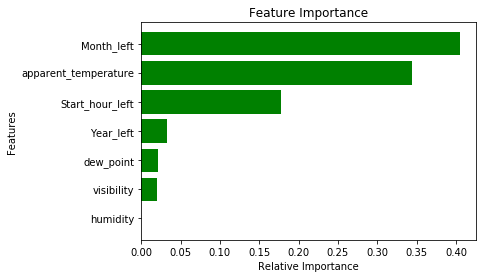

In [358]:
# feature importance
def random_forest_varimp(rf_model, features):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)
    
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.show()
    
random_forest_varimp(rf_model, X_train.columns.values)

In [360]:
# now let's train on all data 
print(merged.head())

,Start_hour_left,Month_left,Year_left,apparent_temperature,humidity,dew_point,visibility,power
0,0,10,2017,26.52,1,19.46,3.57,0.0
1,0,10,2017,26.52,1,19.46,3.57,0.0
2,0,10,2017,26.52,1,19.46,3.57,0.0
3,0,10,2017,26.52,1,19.46,3.57,0.0
4,1,10,2017,28.78,1,20.06,3.06,0.0


In [ ]:
# seperate feature and target variables
merged_Y = merged['power']
merged_X = merged[['Start_hour_left','Month_left','Year_left',
                   'apparent_temperature','humidity','dew_point','visibility']]

In [361]:
# check
print("Features :\n", merged_X.head())

Features :
    Start_hour_left  Month_left  Year_left  apparent_temperature  humidity  \
0                0          10       2017                 26.52         1   
1                0          10       2017                 26.52         1   
2                0          10       2017                 26.52         1   
3                0          10       2017                 26.52         1   
4                1          10       2017                 28.78         1   

   dew_point  visibility  
0      19.46        3.57  
1      19.46        3.57  
2      19.46        3.57  
3      19.46        3.57  
4      20.06        3.06  


In [362]:
# check
print("Target :\n", merged_Y.head())

Target :
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: power, dtype: float64


In [364]:
# train model on all data
rf_model =  RandomForestRegressor(n_estimators=600,min_samples_split=2,min_samples_leaf=4,max_depth=50,bootstrap=True)
rf_model.fit(merged_X, merged_Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [365]:
# calculate for the test set
y_test_pred = rf_model.predict(test)

In [366]:
# store predictions in dataframe
predictions = pd.DataFrame()
predictions['datetime'] = weather_forecast['datetime_local']
predictions['power'] = y_test_pred

In [367]:
# save predictions in csv file
predictions.to_csv('predictions.csv', index=False)

In [369]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))